Dataset loaded successfully.

First 5 rows of the dataset:
        Market        Date  Arrivals (Tonnes) Variety  \
0  Gopalavaram  01-01-2022               21.4      V1   
1       Tenali  01-01-2022               15.0      V1   
2         Durg  01-01-2022                1.8      V1   
3  Rajnandgaon  01-01-2022                1.0      V1   
4    Ahmedabad  01-01-2022               37.7   Other   

   Modal Price(Rs./Quintal) State    Year  Month  
0                    1500.0   ANP  2022.0    1.0  
1                    1800.0   ANP  2022.0    1.0  
2                    3800.0   CHH  2022.0    1.0  
3                    2000.0   CHH  2022.0    1.0  
4                    1650.0   GUJ  2022.0    1.0  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157834 entries, 0 to 157833
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Market                    157832 non-null  objec

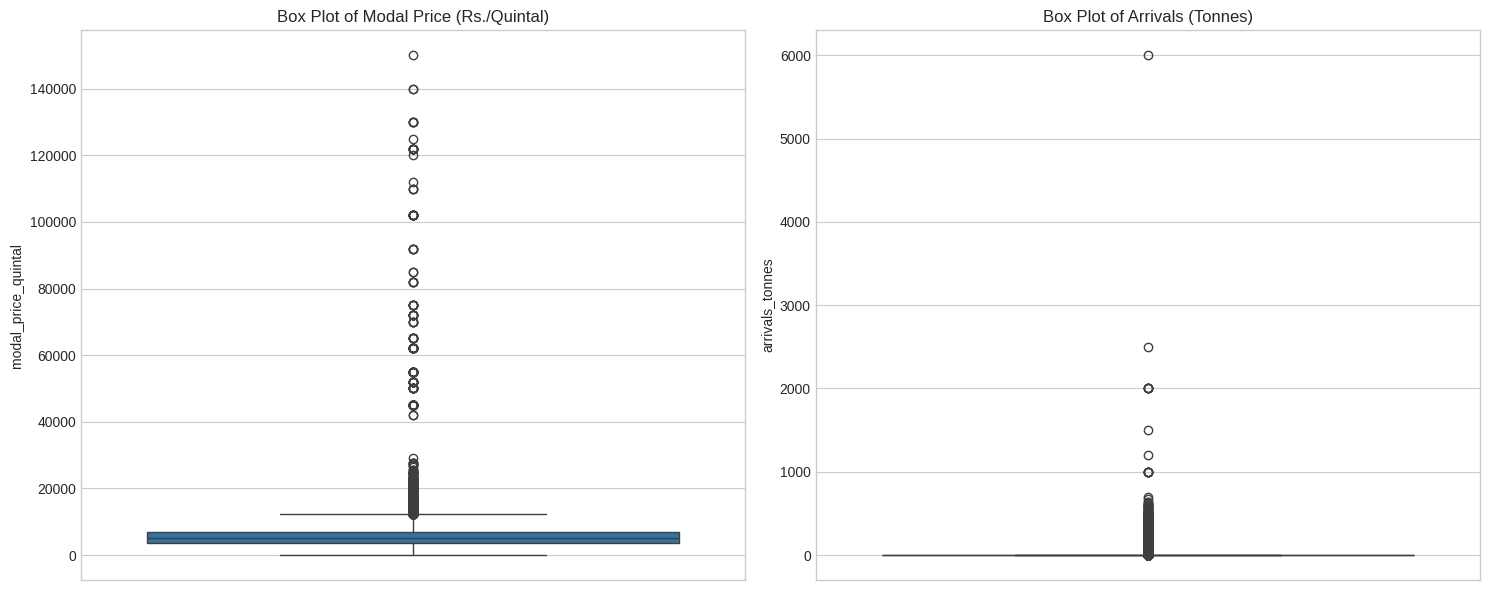


Date column has been set as the index for time series analysis.

Data Cleaning and Outlier Summary:
         Issue Type  Records Affected            Action Taken
0   Missing Variety                 0  Imputed with "Unknown"
1    Price Outliers              8869     Capped at 1.5 * IQR
2  Arrival Outliers             21776     Capped at 1.5 * IQR


In [7]:
# @title 1. Foundational Data Audit and Preparation
# @markdown This section covers the initial data loading, cleaning, and preparation steps.

# @markdown ### 1.0. Environment Setup
# @markdown Install the `prophet` library for forecasting. It is generally more stable and less
# @markdown prone to installation conflicts than other libraries.
!pip install prophet

# @markdown ### 1.1. Data Ingestion and Structural Review
# @markdown Load the dataset, standardize column names, and set up the datetime index.

# Import necessary libraries for data manipulation, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

# Load the dataset from the CSV file
# Note: You will need to upload 'LemonPrices.csv' to your Colab environment.
try:
    df = pd.read_csv('LemonPrices.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'LemonPrices.csv' not found. Please upload the file to your Colab session.")
    # Create a dummy dataframe to allow the rest of the code to run without errors
    df = pd.DataFrame({
        'Market': ['MarketA'], 'Date': ['01-01-2022'], 'Arrivals (Tonnes)': [1],
        'Variety': ['V1'], 'Modal Price(Rs./Quintal)': [2000], 'State': ['StateA'],
        'Year': [2022], 'Month': [1]
    })
    print("A dummy dataframe has been created to proceed. Please upload the correct file for actual analysis.")


# Display the first few rows to understand the data structure
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display a concise summary of the DataFrame, including data types and non-null counts
print("\nDataFrame Info:")
df.info()

# Standardize column names for easier access
df.columns = ['market', 'date', 'arrivals_tonnes', 'variety', 'modal_price_quintal', 'state', 'year', 'month']

# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Display the first few rows again to confirm changes
print("\nFirst 5 rows after cleaning:")
print(df.head())


# @markdown ### 1.2. Handling Data Deficiencies and Inconsistencies
# @markdown Check for and impute missing values.

# Check for missing values in each column
print("\nMissing values count per column:")
print(df.isnull().sum())

# Analyze the rows with missing 'variety' information
print("\nRows with missing variety:")
print(df[df['variety'].isnull()])

# Impute missing 'variety' values with 'Unknown' to retain data while acknowledging the information gap
df['variety'].fillna('Unknown', inplace=True)

# Verify that there are no more missing values
print("\nMissing values count after imputation:")
print(df.isnull().sum())


# @markdown ### 1.3. Outlier Detection and Treatment Strategy
# @markdown Visualize distributions and apply capping to handle extreme outliers.

# Visualize the distribution of modal price and arrivals to identify potential outliers
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
# Use the DataFrame directly without a date index for this plot to avoid errors
sns.boxplot(y=df['modal_price_quintal'])
plt.title('Box Plot of Modal Price (Rs./Quintal)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['arrivals_tonnes'])
plt.title('Box Plot of Arrivals (Tonnes)')

plt.tight_layout()
plt.show()

# Set the 'date' column as the index of the DataFrame for time series analysis
df.set_index('date', inplace=True)
print("\nDate column has been set as the index for time series analysis.")


# Define a function to cap outliers using the IQR method
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(series, lower_bound, upper_bound)

# Create a copy of the dataframe to store cleaned data
df_cleaned = df.copy()

# Apply the outlier capping function to price and arrivals columns
df_cleaned['modal_price_quintal'] = cap_outliers(df_cleaned['modal_price_quintal'])
df_cleaned['arrivals_tonnes'] = cap_outliers(df_cleaned['arrivals_tonnes'])

# Create a summary table of the cleaning actions
cleaning_summary = {
    'Issue Type': ['Missing Variety', 'Price Outliers', 'Arrival Outliers'],
    'Records Affected': [
        df['variety'].isnull().sum(),
        (df['modal_price_quintal'] != df_cleaned['modal_price_quintal']).sum(),
        (df['arrivals_tonnes'] != df_cleaned['arrivals_tonnes']).sum()
    ],
    'Action Taken': ['Imputed with "Unknown"', 'Capped at 1.5 * IQR', 'Capped at 1.5 * IQR']
}
cleaning_summary_df = pd.DataFrame(cleaning_summary)
print("\nData Cleaning and Outlier Summary:")
print(cleaning_summary_df)


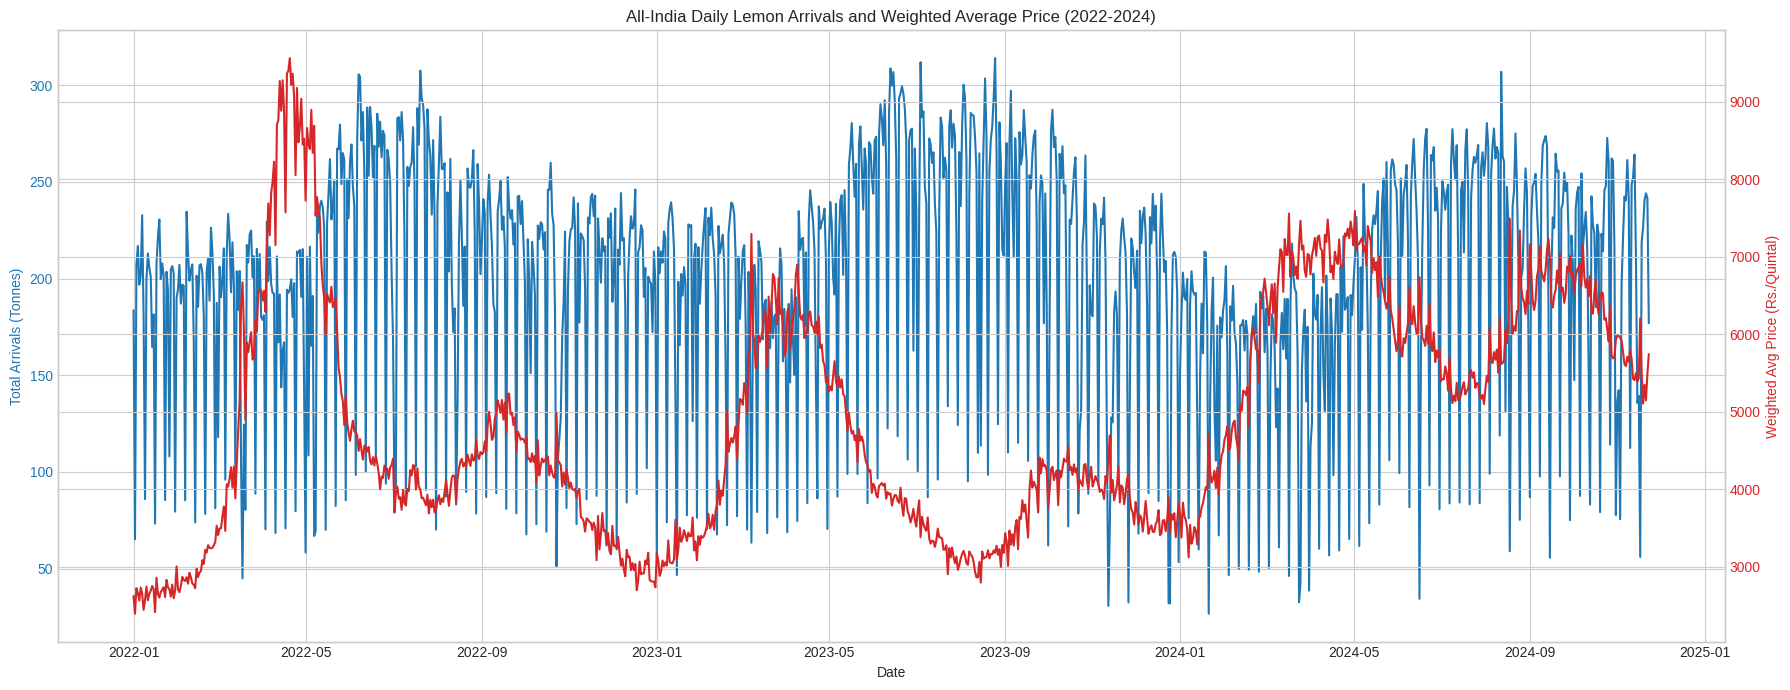


Top 5 states by total arrivals: ['UTP', 'GUJ', 'PUN', 'KER', 'RAJ']


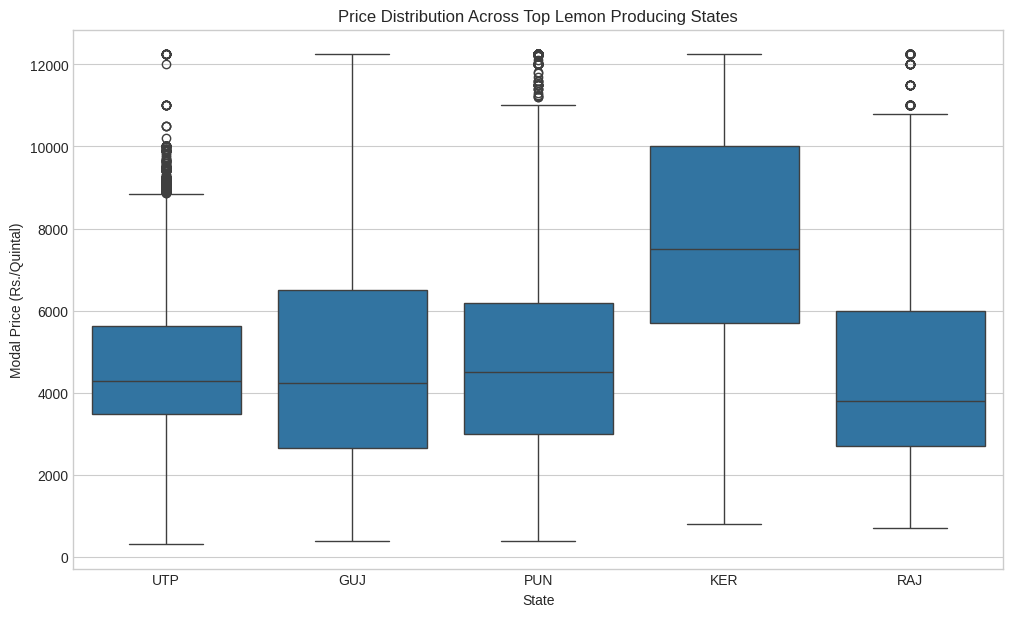

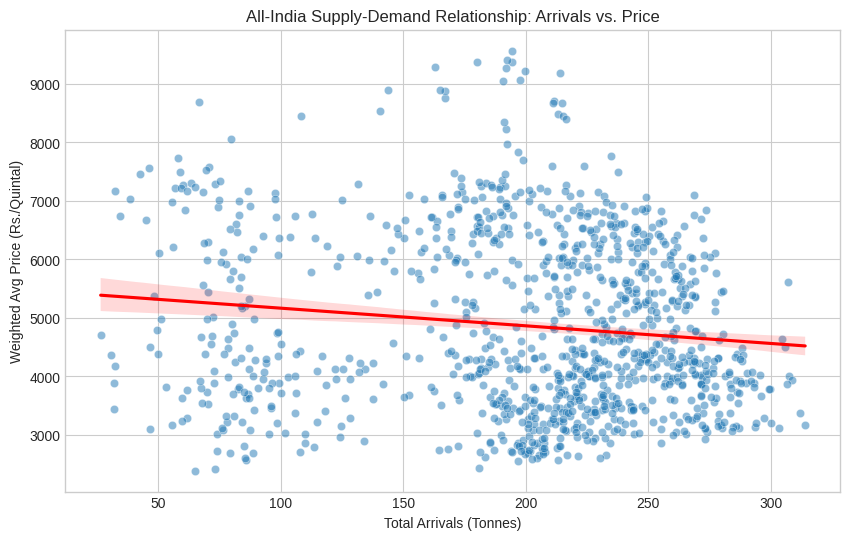

In [8]:

# @title 2. Exploratory Analysis: Uncovering Market Behaviour
# @markdown This section explores the data to find trends, patterns, and relationships.

# @markdown ### 2.1. Pan-India Market Pulse: Aggregated Trends
# @markdown Aggregate data to a national level and visualize overall market behavior.

# Calculate the daily weighted average price for All-India
# Weighted Price = sum(price * arrivals) / sum(arrivals)
daily_weighted_price = df_cleaned.groupby('date').apply(lambda x: np.average(x['modal_price_quintal'], weights=x['arrivals_tonnes']))
daily_total_arrivals = df_cleaned.groupby('date')['arrivals_tonnes'].sum()

# Create a new DataFrame for All-India data
df_india = pd.DataFrame({'weighted_avg_price': daily_weighted_price, 'total_arrivals': daily_total_arrivals})

# Plot the All-India daily arrivals and weighted average price
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(18, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Arrivals (Tonnes)', color=color)
ax1.plot(df_india.index, df_india['total_arrivals'], color=color, label='Total Arrivals')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('All-India Daily Lemon Arrivals and Weighted Average Price (2022-2024)')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Weighted Avg Price (Rs./Quintal)', color=color)
ax2.plot(df_india.index, df_india['weighted_avg_price'], color=color, label='Weighted Avg Price')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


# @markdown ### 2.2. State-Level Market Comparison
# @markdown Compare price distributions across the top states by arrival volume.

# Identify top states by total arrivals
top_states = df_cleaned.groupby('state')['arrivals_tonnes'].sum().nlargest(5).index.tolist()
print(f"\nTop 5 states by total arrivals: {top_states}")

# Filter data for top states
df_top_states = df_cleaned[df_cleaned['state'].isin(top_states)]

# Plot price distributions for top states using box plots
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_top_states, x='state', y='modal_price_quintal', order=top_states)
plt.title('Price Distribution Across Top Lemon Producing States')
plt.xlabel('State')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.show()


# @markdown ### 2.3. The Supply-Demand Nexus
# @markdown Visualize the relationship between price and arrivals.

# Create a scatter plot to visualize the relationship between arrivals and price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_india, x='total_arrivals', y='weighted_avg_price', alpha=0.5)
sns.regplot(data=df_india, x='total_arrivals', y='weighted_avg_price', scatter=False, color='red')
plt.title('All-India Supply-Demand Relationship: Arrivals vs. Price')
plt.xlabel('Total Arrivals (Tonnes)')
plt.ylabel('Weighted Avg Price (Rs./Quintal)')
plt.show()



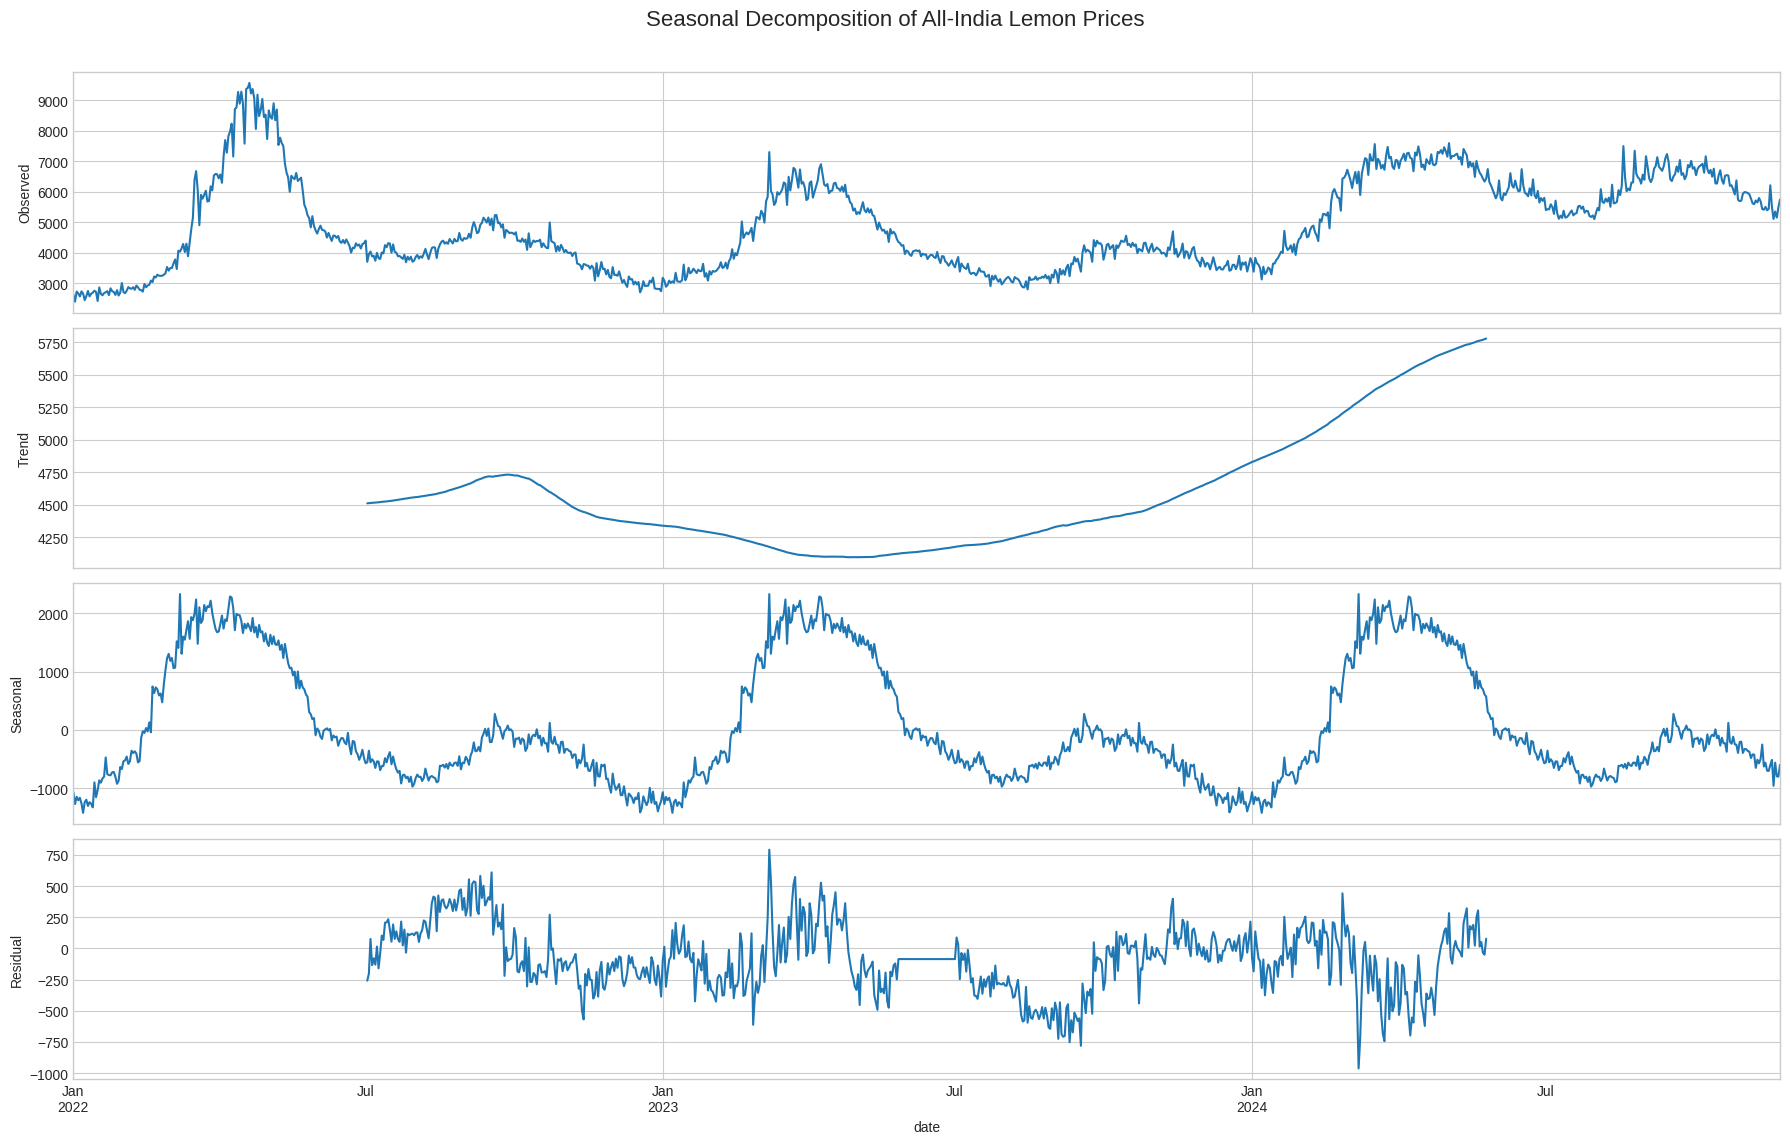

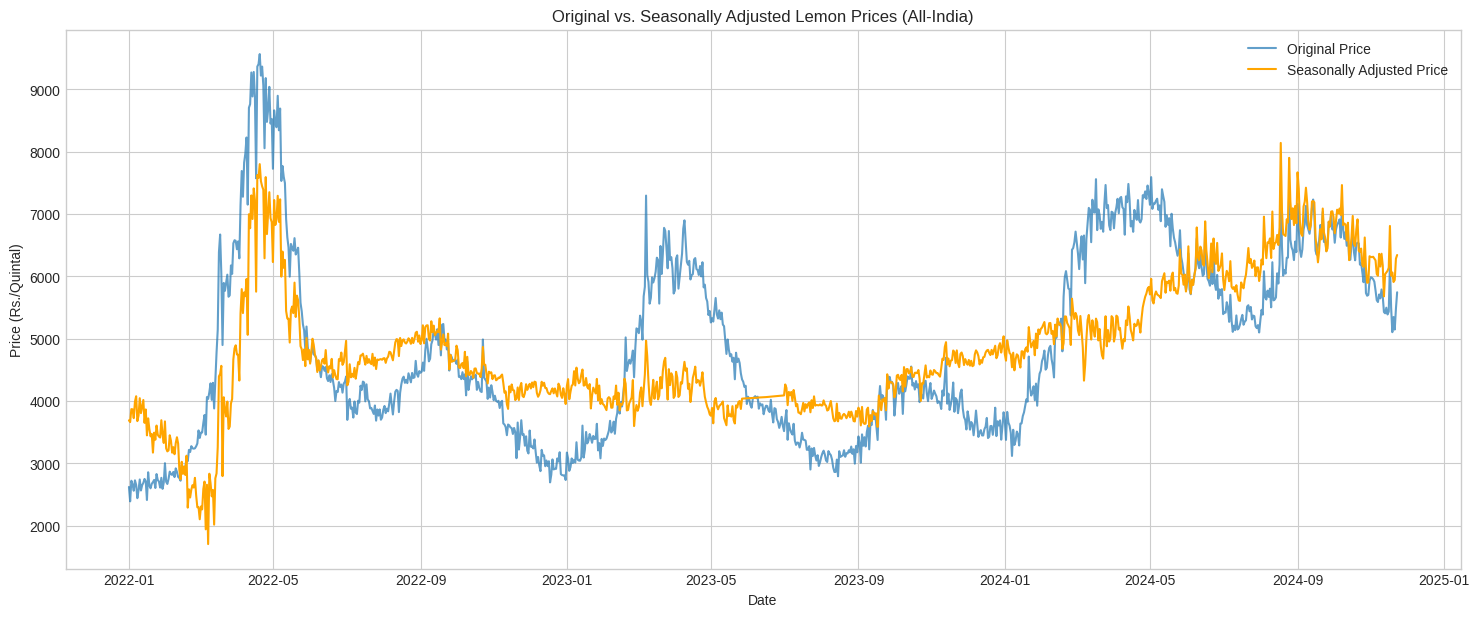

In [9]:

# @title 3. Deconstructing Price Seasonality
# @markdown This section uses time series decomposition to isolate trend, seasonal, and residual components.

# @markdown ### 3.1. Time Series Decomposition
# @markdown Perform and plot the decomposition of the All-India price series.

# Resample the All-India data to ensure there are no gaps, filling with the last known value
df_india_resampled = df_india['weighted_avg_price'].resample('D').ffill()

# Perform seasonal decomposition on the daily weighted average price
# The period is set to 365 to capture the annual seasonal cycle in daily data
decomposition = seasonal_decompose(df_india_resampled, model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.suptitle('Seasonal Decomposition of All-India Lemon Prices', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# @markdown ### 3.3. Deriving Seasonally Adjusted Prices
# @markdown Calculate and visualize the seasonally adjusted price series.

# Calculate the seasonally adjusted price series
df_india['seasonally_adjusted_price'] = df_india_resampled - decomposition.seasonal

# Plot the original vs. seasonally adjusted price series
plt.figure(figsize=(18, 7))
plt.plot(df_india.index, df_india['weighted_avg_price'], label='Original Price', alpha=0.7)
plt.plot(df_india.index, df_india['seasonally_adjusted_price'], label='Seasonally Adjusted Price', color='orange')
plt.title('Original vs. Seasonally Adjusted Lemon Prices (All-India)')
plt.xlabel('Date')
plt.ylabel('Price (Rs./Quintal)')
plt.legend()
plt.show()



In [10]:

# @title 4. Establishing Price Benchmarks
# @markdown This section calculates and displays yearly and monthly price summaries.

# @markdown ### 4.2. Tabulated Price Summaries
# @markdown Generate tables for yearly average prices and a monthly seasonal index.

# Calculate yearly weighted average prices for All-India and top states
yearly_prices = {}
# All-India
yearly_prices['All India'] = df_cleaned.groupby(df_cleaned.index.year).apply(lambda x: np.average(x['modal_price_quintal'], weights=x['arrivals_tonnes']))

# Key States
for state in top_states:
    state_df = df_cleaned[df_cleaned['state'] == state]
    if not state_df.empty:
        yearly_prices[state] = state_df.groupby(state_df.index.year).apply(lambda x: np.average(x['modal_price_quintal'], weights=x['arrivals_tonnes']))

yearly_prices_df = pd.DataFrame(yearly_prices)
print("\nYearly Weighted Average Prices (Rs./Quintal):")
print(yearly_prices_df.round(2))

# Calculate Monthly Seasonal Price Index
monthly_seasonal_component = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()
# The overall mean of the seasonal component should be close to zero for an additive model.
# To create a meaningful index, we calculate it relative to the overall average price.
overall_avg_price = df_india['weighted_avg_price'].mean()
seasonal_index = ((overall_avg_price + monthly_seasonal_component) / overall_avg_price) * 100

monthly_index_df = pd.DataFrame({'Month': range(1, 13), 'Seasonal Index': seasonal_index.values})
monthly_index_df.set_index('Month', inplace=True)
print("\nMonthly Seasonal Price Index (All-India):")
print(monthly_index_df.round(2))



Yearly Weighted Average Prices (Rs./Quintal):
        All India      UTP      GUJ      PUN      KER      RAJ
date                                                          
2022.0    4480.51  4344.04  4508.49  3900.55  6390.86  3752.02
2023.0    4118.71  3995.44  3760.20  3352.16  7227.39  3217.30
2024.0    5999.49  5549.70  6234.88  4998.79  8822.42  5556.78

Monthly Seasonal Price Index (All-India):
       Seasonal Index
Month                
1               79.62
2              101.88
3              135.84
4              137.63
5              120.16
6               95.99
7               86.66
8               85.67
9               97.06
10              96.13
11              87.98
12              76.35


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/obuplch5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/nq8dmhrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86776', 'data', 'file=/tmp/tmp_j0dsfk7/obuplch5.json', 'init=/tmp/tmp_j0dsfk7/nq8dmhrh.json', 'output', 'file=/tmp/tmp_j0dsfk7/prophet_modelj03__68s/prophet_model-20250729193353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Model Components (All-India):


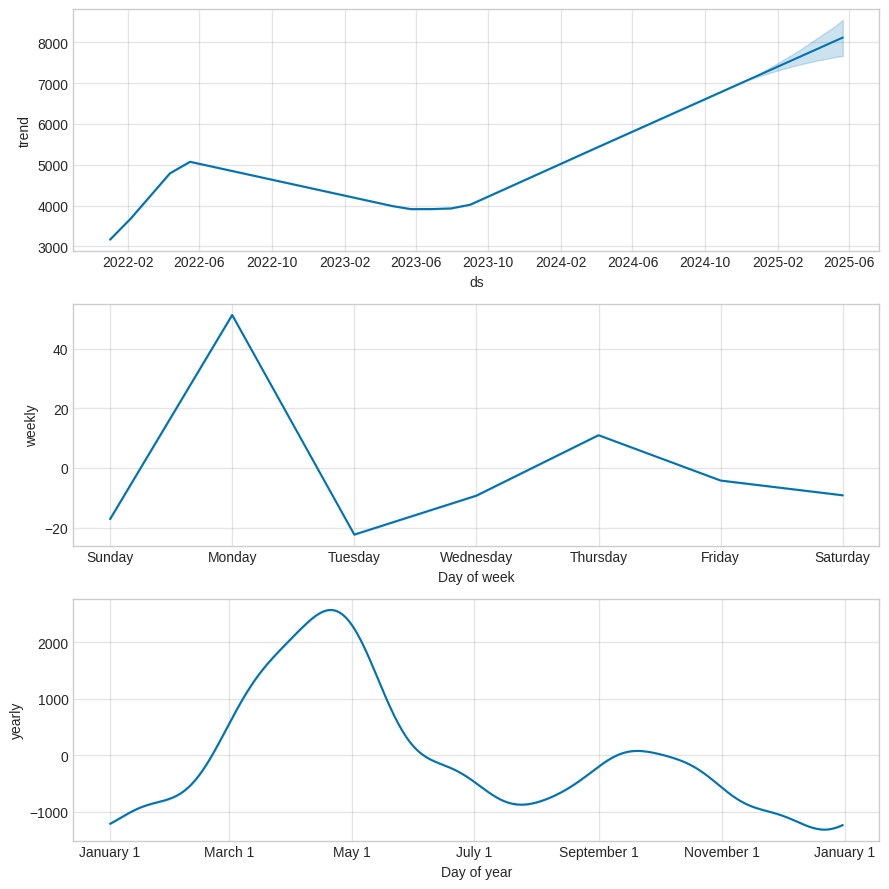


Price Forecast for the Next Two Quarters (All-India):


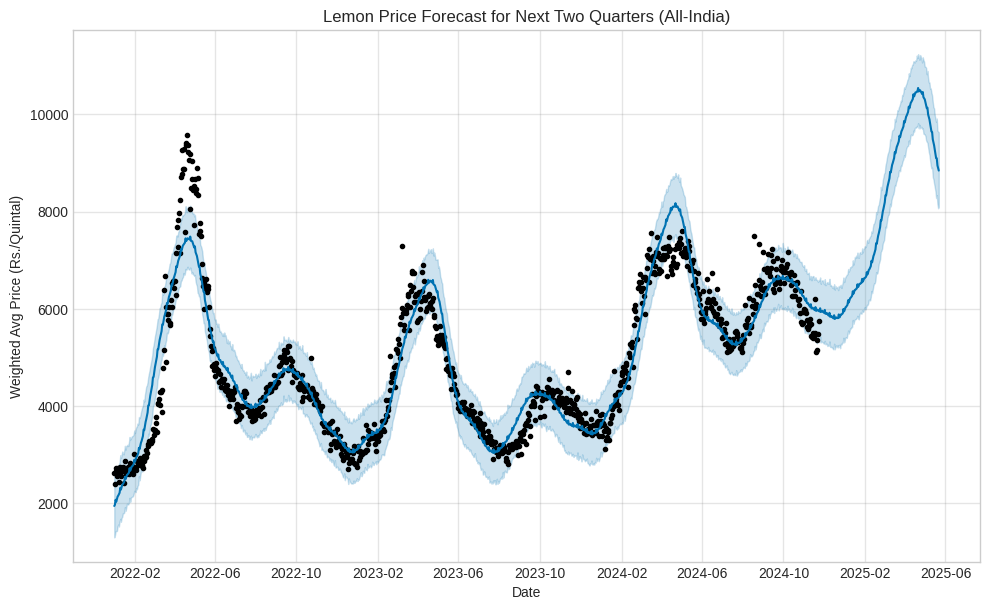


Two-Quarter Price Forecast Table (Monthly Average, All-India):
                yhat  yhat_lower  yhat_upper
ds                                          
2024-11-30   5951.33     5326.95     6573.67
2024-12-31   5867.13     5251.55     6490.03
2025-01-31   6347.80     5721.61     6979.23
2025-02-28   7230.49     6589.68     7864.42
2025-03-31   9063.93     8393.93     9731.34
2025-04-30  10293.83     9581.24    10988.52
2025-05-31   9603.90     8853.68    10351.94

--- Generating forecast for UTP ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/8xas43cc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/ba9cten8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52438', 'data', 'file=/tmp/tmp_j0dsfk7/8xas43cc.json', 'init=/tmp/tmp_j0dsfk7/ba9cten8.json', 'output', 'file=/tmp/tmp_j0dsfk7/prophet_modeljhb01rzy/prophet_model-20250729193356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/tz27tl9o.json



--- Generating forecast for GUJ ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/nhk6v161.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66351', 'data', 'file=/tmp/tmp_j0dsfk7/tz27tl9o.json', 'init=/tmp/tmp_j0dsfk7/nhk6v161.json', 'output', 'file=/tmp/tmp_j0dsfk7/prophet_modelsd71h2b0/prophet_model-20250729193356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Generating forecast for PUN ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/8x9_ci_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/ykaoinjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89427', 'data', 'file=/tmp/tmp_j0dsfk7/8x9_ci_a.json', 'init=/tmp/tmp_j0dsfk7/ykaoinjf.json', 'output', 'file=/tmp/tmp_j0dsfk7/prophet_model60jwa6_a/prophet_model-20250729193357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Generating forecast for KER ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/qpsriv25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/zyh_jwqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42695', 'data', 'file=/tmp/tmp_j0dsfk7/qpsriv25.json', 'init=/tmp/tmp_j0dsfk7/zyh_jwqw.json', 'output', 'file=/tmp/tmp_j0dsfk7/prophet_model0b5fsjsu/prophet_model-20250729193358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Generating forecast for RAJ ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/um879dp0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j0dsfk7/q7hlfzhn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=331', 'data', 'file=/tmp/tmp_j0dsfk7/um879dp0.json', 'init=/tmp/tmp_j0dsfk7/q7hlfzhn.json', 'output', 'file=/tmp/tmp_j0dsfk7/prophet_modelttujdz9j/prophet_model-20250729193400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:34:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


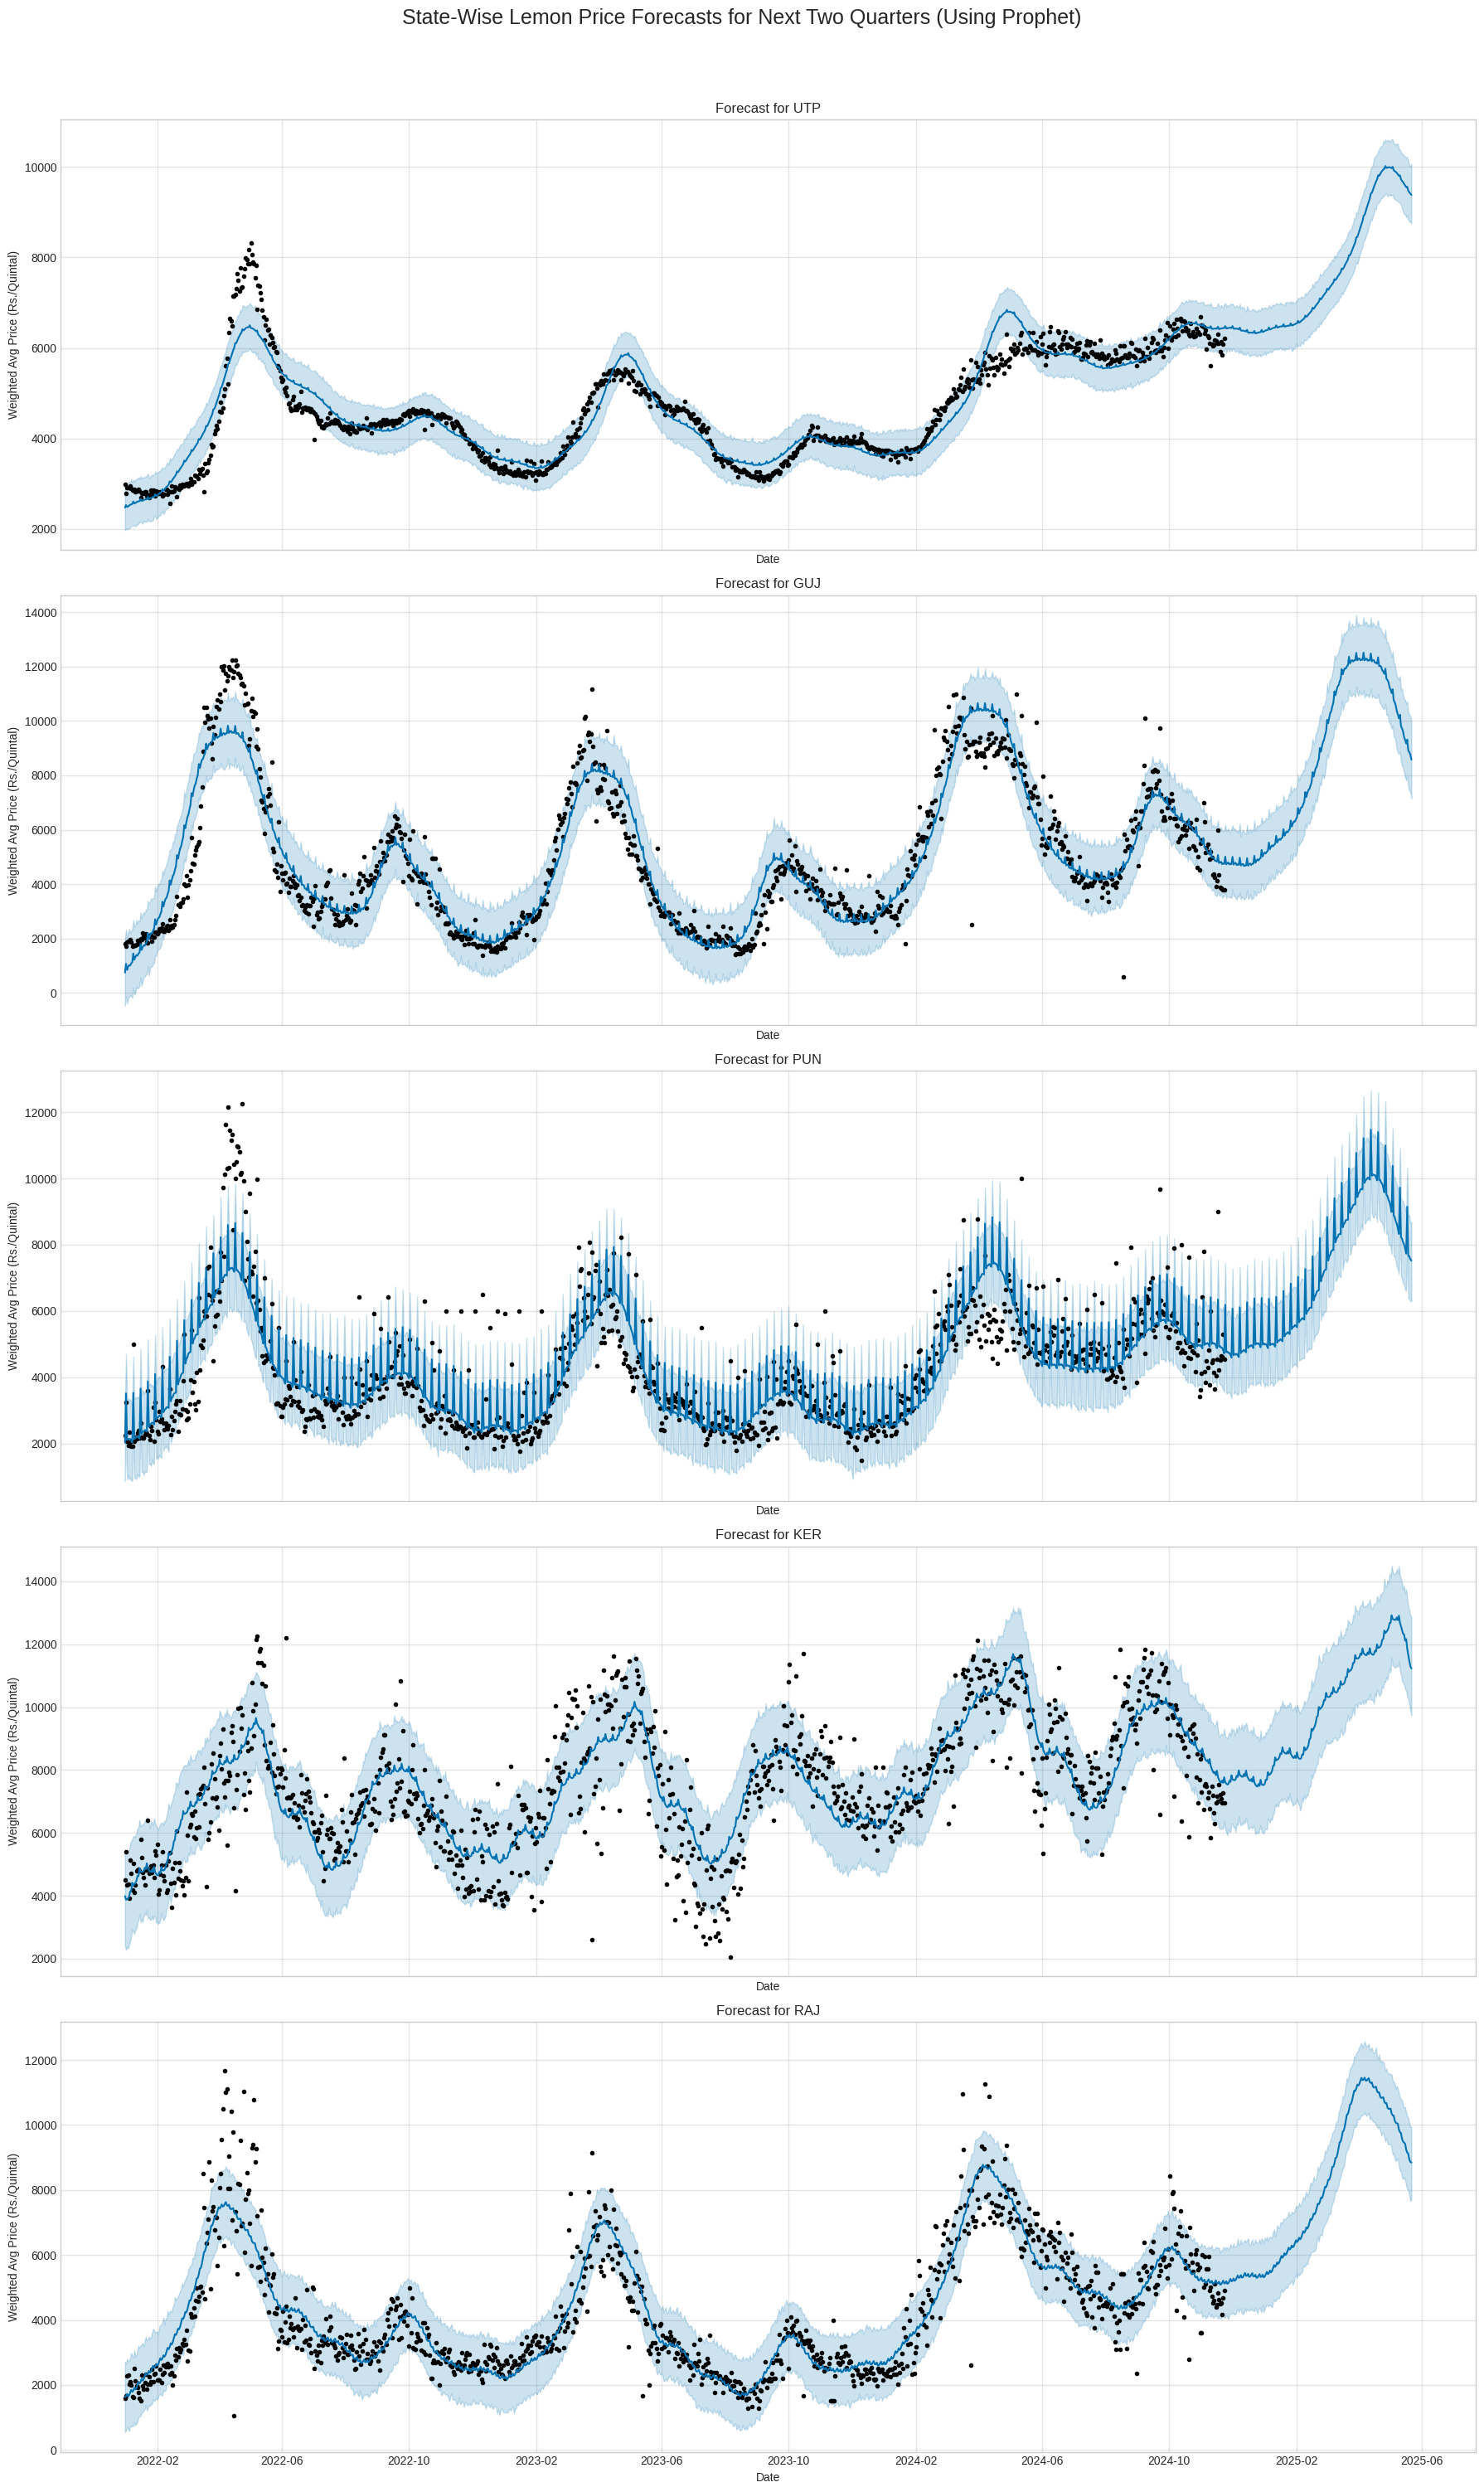


State-Wise Two-Quarter Price Forecast Table (Monthly Average, Rs./Quintal):
            yhat      yhat      yhat      yhat      yhat
ds                                                      
2024-11  6445.24   4787.51   4919.85   7627.33   5173.38
2024-12  6375.52   4825.71   5075.50   7702.31   5337.23
2025-01  6465.93   5722.69   5353.74   8287.61   5858.10
2025-02  6834.08   7831.28   6455.48   9186.37   7124.58
2025-03  7766.04  11422.36   8660.39  10829.69   9656.68
2025-04  9437.10  12104.11  10022.49  11896.95  11108.96
2025-05  9735.72   9955.48   8500.90  12369.00   9714.74


In [11]:

# @title 5. Predictive Modelling with Prophet
# @markdown This section builds and evaluates a Prophet model for robust forecasting.

# @markdown ### 5.1. Model Building and Forecasting (All-India)
# @markdown Prepare data, build the model, generate the forecast, and inspect its components.

# Prophet requires the columns to be named 'ds' (for date) and 'y' (for the value to forecast)
df_prophet = df_india.reset_index()[['date', 'weighted_avg_price']].rename(columns={'date': 'ds', 'weighted_avg_price': 'y'})

# Initialize and fit the Prophet model
# Prophet automatically detects yearly and weekly seasonality.
model_india = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_india.fit(df_prophet)

# Create a future dataframe for the next 180 days (approx. 2 quarters)
future_india = model_india.make_future_dataframe(periods=180)

# Generate the forecast. This dataframe contains the predictions and all components.
forecast_india = model_india.predict(future_india)

# --- Plot 1: Forecast Components ---
# Prophet's component plot provides insights similar to seasonal decomposition
print("\nProphet Model Components (All-India):")
fig_components = model_india.plot_components(forecast_india)
plt.show()

# --- Plot 2: Main Forecast ---
# Plot the overall forecast against historical data
print("\nPrice Forecast for the Next Two Quarters (All-India):")
fig_forecast = model_india.plot(forecast_india)
plt.title('Lemon Price Forecast for Next Two Quarters (All-India)')
plt.xlabel('Date')
plt.ylabel('Weighted Avg Price (Rs./Quintal)')
plt.show()

# Display the forecast table for the future period
forecast_table_india = forecast_india.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].tail(180)
print("\nTwo-Quarter Price Forecast Table (Monthly Average, All-India):")
print(forecast_table_india.resample('M').mean().round(2))


# @markdown ### 5.2. State-Wise Price Forecasts for Key Markets
# @markdown Apply the robust Prophet forecasting methodology to each of the top 5 states.

# Create a dictionary to store state-specific forecasts and models
state_forecasts_prophet = {}

# Loop through each of the top states identified earlier
for state in top_states:
    print(f"\n--- Generating forecast for {state} ---")

    # 1. Create state-specific time series
    df_state = df_cleaned[df_cleaned['state'] == state].copy()
    daily_weighted_price_state = df_state.groupby('date').apply(lambda x: np.average(x['modal_price_quintal'], weights=x['arrivals_tonnes']))

    # Resample to daily frequency and forward-fill missing dates to create a continuous series
    df_state_resampled = daily_weighted_price_state.resample('D').ffill().reset_index()
    df_state_prophet = df_state_resampled.rename(columns={'date': 'ds', 0: 'y'})

    # 2. Build Prophet model for the state
    model_state = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_state.fit(df_state_prophet)

    # 3. Generate forecasts for the next 180 days
    future_state = model_state.make_future_dataframe(periods=180)
    forecast_state = model_state.predict(future_state)

    # 4. Store the results for plotting and tabulation
    state_forecasts_prophet[state] = {
        'model': model_state,
        'forecast': forecast_state
    }

# Plotting the state-wise forecasts for comparison
num_states = len(state_forecasts_prophet)
fig, axes = plt.subplots(num_states, 1, figsize=(18, 6 * num_states), sharex=True)
fig.suptitle('State-Wise Lemon Price Forecasts for Next Two Quarters (Using Prophet)', fontsize=18, y=1.0)

if num_states == 1:
    axes = [axes]

for i, state in enumerate(state_forecasts_prophet.keys()):
    ax = axes[i]
    state_data = state_forecasts_prophet[state]

    state_data['model'].plot(state_data['forecast'], ax=ax)
    ax.set_title(f'Forecast for {state}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weighted Avg Price (Rs./Quintal)')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Create a consolidated forecast table for all top states
monthly_forecast_dfs = []
for state, data in state_forecasts_prophet.items():
    forecast_df = data['forecast'].set_index('ds')[['yhat']].tail(180)
    monthly_avg = forecast_df.resample('M').mean().round(2)
    monthly_avg.name = state
    monthly_forecast_dfs.append(monthly_avg)

# Combine all state forecasts into a single DataFrame
state_forecast_table = pd.concat(monthly_forecast_dfs, axis=1)
state_forecast_table.index = state_forecast_table.index.strftime('%Y-%m')

print("\nState-Wise Two-Quarter Price Forecast Table (Monthly Average, Rs./Quintal):")
print(state_forecast_table)
